In [1]:
# Install bertopic
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039282 sha256=d161b2bc05fa982634aba2fdd93cdf23b579b56e505529ac119f269cc7d5fbab
  Stored in dir

In [2]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Visualization
import seaborn as sns

# Text preprocessiong
import nltk
nltk.download('stopwords')

# Dimension reduction
from umap import UMAP

# Clustering
from hdbscan import HDBSCAN

# Count vectorization
from sklearn.feature_extraction.text import CountVectorizer

# Topic model
from bertopic import BERTopic

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Read in data
df = pd.read_csv('reviews.csv.gz', nrows=10000, usecols=['comments', 'date'], compression='gzip')

# Change date to datetime format
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# Take a look at the data
df.head()

,date,comments
0,2012-12-04,Yvette picked us up from the bus stop on our a...
1,2012-12-08,"Lovely house with beautiful views, close to th..."
2,2012-12-20,Yvette is a generous host and a georgeous pers...
3,2012-12-23,This is our first experience with Air B & B; a...
4,2012-12-31,Yvette is a very friendly host and happy to gi...


.info helps us to get information about the dataset.

From the output, we can see that this data set has 10000 records and no missing data. The comments column is the object type and the date column is the datetime64 type.

In [7]:
# Get the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      10000 non-null  datetime64[ns]
 1   comments  10000 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 156.4+ KB


In [8]:
# Start date of the reviews
start_date = df['date'].min()

# Ending date of the reviews
end_date = df['date'].max()

# Time range
print(f'The time range for the review is {start_date} to {end_date}')

The time range for the review is 2011-05-16 00:00:00 to 2023-09-03 00:00:00


To examine the number of reviews by year, we extract the year information from the date column using DatetimeIndex().year, and save it as a separate column.

Airbnb was founded in August 2008. The countplot shows that there were very few reviews in 2009. The number increased over the years and became relatively stable from 2013 to 2019. There was a big drop in the number of reviews in 2020 due to COVID. Although the number of reviews are increasing since 2020, it is still much lower than the number before the pandemic.

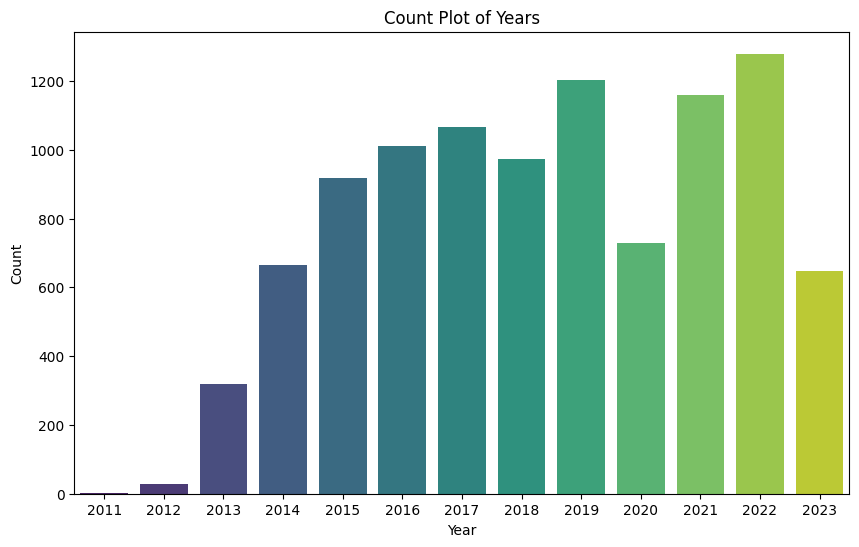

In [9]:

# Create the year variable
df['year'] = pd.DatetimeIndex(df['date']).year
# Count plot
# Create a count plot for the 'year' variable
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=df, palette='viridis')
plt.title('Count Plot of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


we will remove the noises from the top words of the topic model.

There are three types of noises that impact the topic modeling results and interpretation, stop words, persons' names, and domain-specific words.

Stop words are the words that commonly appear in sentences but have no real meanings such as the and for. There are 179 stop words in the Python package NLTK.

In [10]:
# NLTK English stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Print out the NLTK default stopwords
print(f'There are {len(stopwords)} default stopwords. They are {stopwords}')

There are 179 default stopwords. They are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'no

In [12]:
# Read in names
names = pd.read_csv('surnames.csv', usecols=['Name'])

# Host name list
name_list = names['Name'].str.lower().tolist()

# Host's name list
names_list = list(map(( lambda x: str(x)+'s'), name_list))

# Print out the number of names
print(f'There are {len(name_list)} names in the surname list, and the top three names are {name_list[:3]}.')

There are 41 names in the surname list, and the top three names are ['smith', 'jones', 'williams'].


In [13]:
# Domain specific words to remove
airbnb_related_words = ['stay', 'airbnb', 'dc', 'would', 'time']

In [14]:
# Other words to remove
other_words_to_remove = ['natasha', 'also', 'vladi']

In [15]:
# Expand stopwords
stopwords.extend(name_list + names_list + airbnb_related_words + other_words_to_remove)
print(f'There are {len(stopwords)} stopwords.')

There are 269 stopwords.


In this step, the time information is ignored and all the reviews are used to build the topic model. The output from the topic model will be used as the foundation for the time series analysis.

BERTopic model uses UMAP (Uniform Manifold Approximation & Projection) dimensionality reduction. BERTopic by default produces different results each time because of the stochasticity inherited from UMAP.

To get reproducible topics, we need to pass a value to the random_state parameter in the UMAP method.

n_neighbors=15 means that the local neighborhood size for UMAP is 15. This is the parameter that controls the local versus global structure in data.
A low value forces UMAP to focus more on local structure, and may lose insights into the big picture.
A high value pushes UMAP to look at the broader neighborhood, and may lose details on local structure.
The default n_neighbors value for UMAP is 15.
n_components=5 indicates that the target dimension from UMAP is 5. This is the dimension of data that will be passed into the clustering model.
min_dist controls how tightly UMAP is allowed to pack points together. It's the minimum distance between points in the low-dimensional space.
Small values of min_dist result in clumpier embeddings, which is good for clustering. Since our goal of dimension reduction is to build clustering models, we set min_dist to 0.
Large values of min_dist prevent UMAP from packing points together and preserves the broad structure of data.
metric='cosine' indicates that we will use cosine to measure the distance.
random_state sets a random seed to make the UMAP results reproducible.
CountVectorizer is for counting the words frequency. Passing the extended stop words list helps us to remove noises from the top words representing each topic.

In [16]:
from bertopic import BERTopic

In [17]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Count vectorizer
vectorizer_model = CountVectorizer(stop_words=stopwords)

In the BERTopic function, we tuned a few hyperparameters. To learn more about hyperparameter tuning, Please check out my previous tutorial Hyperparameter Tuning for BERTopic Model in Python.

umap_model takes the model for dimensionality reduction. We are using the UMAP model for this tutorial, but it can be other dimensionality reduction models such as PCA (Principle Component Analysis).
vectorizer_model takes the term vectorization model. The extended stop words list is passed into the BERTopic model through CountVectorizer.
diversity helps to remove the words with the same or similar meanings. It has a range of 0 to 1, where 0 means least diversity and 1 means most diversity.
min_topic_size is the minimum number of documents in a topic. min_topic_size=200 means that a topic needs to have at least 200 reviews.
top_n_words=4 indicates that we will use the top 4 words to represent the topic.
language has English as the default. We set it to multilingual because there are multiple languages in the Airbnb reviews.
calculate_probabilities=True means that the probabilities of each document belonging to each topic are calculated. The topic with the highest probability is the predicted topic for a new document. This probability represents how confident we are about finding the topic in the document.

In [18]:
# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model,
                       vectorizer_model=vectorizer_model,
                       min_topic_size=200,
                       top_n_words=4,
                       language="multilingual",
                       calculate_probabilities=True)

# Run BERTopic model
topics = topic_model.fit_transform(df['comments'])

# Get the list of topics
topic_model.get_topic_info()

.gitattributes:   0%|          | 0.00/968 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2276,-1_br_place_great_house,"[br, place, great, house]",[We had an amazing stay at Christine and Renat...
1,0,5075,0_great_place_location_br,"[great, place, location, br]","[Great comfortable place!, We loved everything..."
2,1,1169,1_hobart_great_br_apartment,"[hobart, great, br, apartment]",[We had a wonderful stay in Tracey’s apartment...
3,2,414,2_freya_glebe_emporium_hobart,"[freya, glebe, emporium, hobart]",[Glebe Emporium was a great place to stay. It’...
4,3,390,3_jill_mandy_host_us,"[jill, mandy, host, us]",[Jill was a wonderful host; her apartment was ...
5,4,238,4_craig_adam_us_home,"[craig, adam, us, home]",[Craig & Adam's place is located in the pictur...
6,5,220,5_angela_clive_br_moonah,"[angela, clive, br, moonah]",[The property is stunning with gorgeous views ...
7,6,218,6_yvette_hobart_mitch_house,"[yvette, hobart, mitch, house]",[Yvette was the warm host and the room and fac...


Using the attribute get_topic_info() on the topic model gives us a list of topics. We can see that the output gives us 9 rows in total.

Topic -1 should be ignored. It indicates that the reviews are not assigned to any specific topic. The count for topic -1 is 2442, meaning that there are 2442 outlier reviews that do not belong to any topic.
Topic 0 to topic 8 are the 9 topics created for the reviews. It was ordered by the number of reviews in each topic, so topic 0 has the highest number of reviews.
The Name column lists the top terms for each topic. For example, the top 4 terms for Topic 0 are clean, neighborhood, restaurants, and bed, indicating that it is a topic related to a convenient neighborhood.

The Python BERTopic package calculates topics' evolution over time based on the topic model output. The class-based TF-IDF will be calculated for each topic and timestamp combination. There is no need to rerun the topic model multiple times to create clusters from embeddings for each timestamp.

To get the topic representations over time, we can apply the topics_over_time function on the topic model and pass in the reviews and dates.

global_tuning=True indicates that the topic representation at a certain timestamp is averaged with the global representation of the topic. This helps to increase the similarity between the time-specific topic representation and the overall topic representation.
evolution_tuning=True indicates that the c-TF-IDF at time t is averaged with the c-TF-IDF at time t-1. This moving average step allows a stable evolution of topic representation over time.
Both global_tuning and evolution_tuning have the default value of True, but we can change it to False if we do not want the topic representation influenced by the global topic or the previous timestamp.
nr_bins controls the number of unique timestamps. BERTopic suggests keeping this number below 50. nr_bins=13 means that there will be 13 equal-sized bins for the time.

In [19]:
# Topics over time
topics_over_time = topic_model.topics_over_time(df['comments'],
                                                df['date'],
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=13)

# Take a look at the data
topics_over_time.head()

,Topic,Words,Frequency,Timestamp
0,0,"wedding, use, upload, com",2,2011-05-11 12:10:04.800000000
1,1,"courtesy, success, flexibility, without",1,2011-05-11 12:10:04.800000000
2,-1,"br, gaye, house, place",45,2012-04-25 14:46:09.230769152
3,0,"br, great, house, place",20,2012-04-25 14:46:09.230769152
4,1,"hobart, tracey, br, apartment",21,2012-04-25 14:46:09.230769152


The visualize_topics_over_time function takes in the topics_over_time dataframe and produces the time series graph for topic changes over time.

We can use top_n_topics to limit the number of topics to show in the time series graph.

From the topics over time visualization, we can see that

Topic 0 consistently has the highest review volume since 2010 compared with other topics. Other topics have similar review volumes.
Topic 0 has an upward trend over time before the pandemic, while topic 3 and topic 4 have downward trend since 2012.
Hovering over the timestamp cutoff points shows the topic representation for the topic at that specific timestamp bin. We can see that reviews in topic 0 talk about parking a lot from 2012 to 2015, and parking was not a hot topic anymore between 2016 to 2019. People care more about neighborhoods and restaurants over time.
The legends under the "Global Topic Representation" are clickable. Clicking the legend turns the line on the chart on and off.

In [ ]:
# Visualize topic over time
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

In [21]:
# Visualize specific topics
topic_model.visualize_topics_over_time(topics_over_time, topics=[1, 2])